In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Approximation with a Single Number

## Theory Overview

Let's consider a simple model in which we attempt to represent each observed datum with a single number, so that:

$$x_i \approx \phi h_i + \mu$$

where:
- $\mu$ is the mean of the data set
- $\phi$ is a basis vector mapping the low-dimensional representation back to the original data space
- $h_i$ is the low-dimensional representation of data point $x_i$

For simplicity, we'll assume the mean of the dataset is zero and:

$$x_i \approx \phi h_i$$

This can be achieved by computing the empirical mean $\mu$ and subtracting it from every example $x_i$.

## Optimization Problem

The learning algorithm optimizes the criterion:

$$\hat{\phi}, \hat{h}_1,...,\hat{h}_I = \arg\min_{\phi,h_1...I} [E] = \arg\min_{\phi,h_1...I} \sum_{i=1}^{I} (x_i - \phi h_i)^T (x_i - \phi h_i)$$

## Ambiguity Problem and Solution

There's an immediate problem: the solution is ambiguous as we can multiply the basis function $\phi$ by any constant $k$ and divide each of the hidden variables $\{h_i\}_{i=1}^{I}$ by the same number to yield exactly the same cost.

To resolve this, we force the vector $\phi$ to have unit length. This is accomplished by adding a Lagrange multiplier $\lambda$:

$$E = \sum_{i=1}^{I} (x_i - \phi h_i)^T (x_i - \phi h_i) + \lambda(\phi^T \phi - 1)$$

$$E = \sum_{i=1}^{I} [x_i^T x_i - 2h_i \phi^T x_i + h_i^2] + \lambda(\phi^T \phi - 1)$$

## Finding Optimal Solutions

To minimize the function, we first take the derivative with respect to $h_i$, and then equate the resulting expression to zero:

$$\hat{h}_i = \hat{\phi}^T x_i$$

In other words, to find the reduced dimension representation $h_i$ we simply project the observed data onto the vector $\phi$.

Next, we take the derivative of the cost equation with respect to $\phi$, substitute in the solution for $h_i$, equate the result to zero, and rearrange:

$$\sum_{i=1}^{I} x_i x_i^T \hat{\phi} = \lambda\hat{\phi}$$

Or in matrix form:

$$XX^T \hat{\phi} = \lambda\hat{\phi}$$

where the matrix $X = [x_1, x_2, \ldots, x_I]$ contains the data examples in its columns.

## Solution via Eigenvalue Problem

This is an eigenvalue problem. To find the optimal vector, we compute the SVD $ULV^T = XX^T$ and choose the first column of $U$.

The scatter matrix $XX^T$ is a constant multiple of the covariance matrix, so this has a simple geometric interpretation: the optimal vector $\phi$ to project onto corresponds to the principal direction of the covariance ellipse.

This makes intuitive sense; we retain information from the direction in space where the data vary most.

## Example Code

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate some example 2D data
np.random.seed(42)
n_samples = 100
mean = [0, 0]
cov = [[3, 1.5], [1.5, 1]]  # Covariance matrix
X = np.random.multivariate_normal(mean, cov, n_samples)

# Calculate the mean and center the data
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# Calculate XX^T (scatter matrix)
scatter_matrix = np.dot(X_centered.T, X_centered)

# Get eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(scatter_matrix)
# Sort in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# The first eigenvector is our phi
phi = eigenvectors[:, 0]

# Project the data onto phi to get h values
h = np.dot(X_centered, phi)

# Reconstruct the data using just the first component
X_reconstructed = np.outer(h, phi) + X_mean

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.5, label='Reconstructed Data')
plt.quiver(X_mean[0], X_mean[1], phi[0], phi[1], scale=5, color='r', label='phi (1st eigenvector)')
plt.legend()
plt.axis('equal')
plt.title('Data Approximation with a Single Number (PCA)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()
```

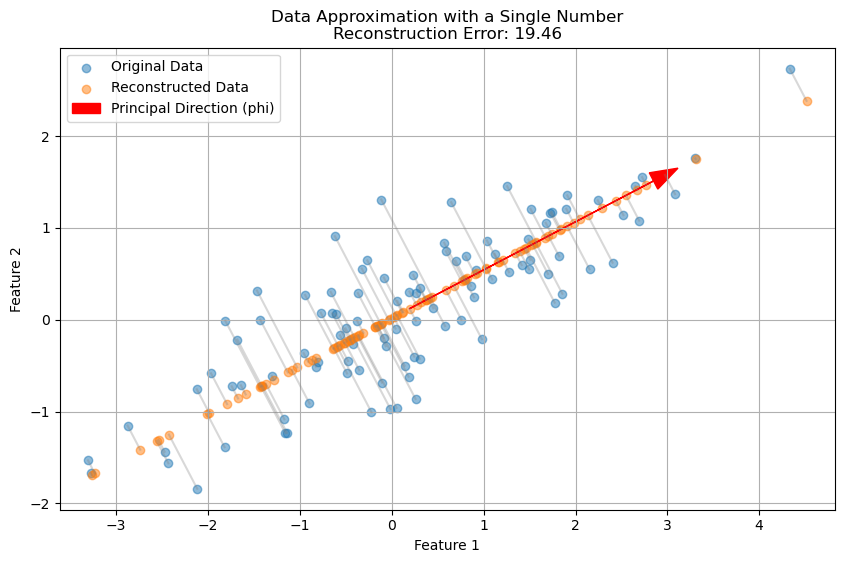

Mean of the data: [0.19156339 0.11965866]
Principal direction (phi): [0.88599549 0.46369385]
Eigenvalue: 276.08043454713976
Reconstruction error: 19.458768400278036


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example 2D data
np.random.seed(42)
n_samples = 100
mean = [0, 0]
cov = [[3, 1.5], [1.5, 1]]  # Covariance matrix
X = np.random.multivariate_normal(mean, cov, n_samples)

# Step 1: Calculate the mean and center the data
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

# Step 2: Calculate XX^T (scatter matrix)
# Note: For actual PCA, we'd use X_centered.T @ X_centered / (n_samples-1)
# But for matching the equations in your material exactly, we use:
scatter_matrix = X_centered.T @ X_centered

# Step 3: Compute eigenvalues and eigenvectors of the scatter matrix
# Implementation without using np.linalg.eigh
def power_iteration(A, num_iterations=100, tol=1e-10):
    """
    Compute the dominant eigenvector of matrix A using power iteration method
    """
    # Start with a random vector
    n = A.shape[0]
    b_k = np.random.rand(n)
    
    for _ in range(num_iterations):
        # Calculate the matrix-vector product Ab
        b_k1 = A @ b_k
        
        # Calculate the norm
        b_k1_norm = np.linalg.norm(b_k1)
        
        # Re-normalize the vector
        b_k = b_k1 / b_k1_norm
        
        # Check for convergence
        if np.linalg.norm(A @ b_k - b_k1_norm * b_k) < tol:
            break
    
    # Calculate the Rayleigh quotient (eigenvalue)
    eigenvalue = (b_k.T @ A @ b_k) / (b_k.T @ b_k)
    
    return eigenvalue, b_k

# Compute the first eigenvector (phi) using power iteration
eigenvalue, phi = power_iteration(scatter_matrix)
phi = phi / np.linalg.norm(phi)  # Ensure unit length

# Step 4: Project the data onto phi to get h values (per equation 13.21)
h = X_centered @ phi

# Step 5: Reconstruct the data using just the first component
X_reconstructed = np.outer(h, phi) + X_mean

# Calculate reconstruction error
reconstruction_error = np.sum((X - X_reconstructed)**2)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Original Data')
plt.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], alpha=0.5, label='Reconstructed Data')

# Draw lines between original and reconstructed points
for i in range(n_samples):
    plt.plot([X[i, 0], X_reconstructed[i, 0]], 
             [X[i, 1], X_reconstructed[i, 1]], 'gray', alpha=0.3)

# Plot the principal component direction
scale_factor = 3
plt.arrow(X_mean[0], X_mean[1], 
          scale_factor * phi[0], scale_factor * phi[1], 
          head_width=0.2, head_length=0.3, fc='red', ec='red',
          label='Principal Direction (phi)')

plt.legend()
plt.axis('equal')
plt.title(f'Data Approximation with a Single Number\nReconstruction Error: {reconstruction_error:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

# Print results
print(f"Mean of the data: {X_mean}")
print(f"Principal direction (phi): {phi}")
print(f"Eigenvalue: {eigenvalue}")
print(f"Reconstruction error: {reconstruction_error}")

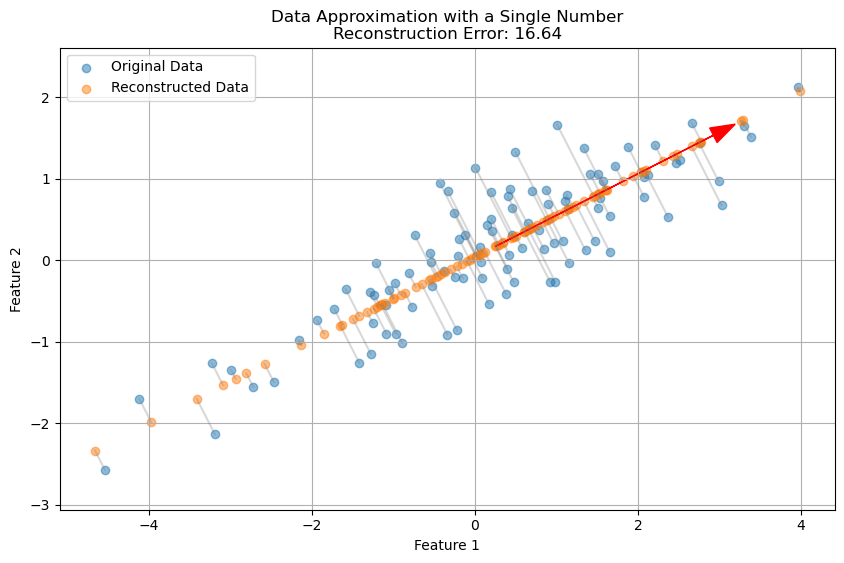

Mean of the data: [0.2504198674788696, 0.16904957310679003]
Principal direction (phi): [0.8909257858415199, 0.4541489228465374]
Eigenvalue: 322.5391774956045
Reconstruction error: 16.64196561205581


In [2]:
import math
import random
import matplotlib.pyplot as plt

# Helper math functions
def dot_product(a, b):
    """Compute the dot product of vectors a and b"""
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def vector_subtract(a, b):
    """Subtract vector b from vector a"""
    return [a_i - b_i for a_i, b_i in zip(a, b)]

def vector_add(a, b):
    """Add vector b to vector a"""
    return [a_i + b_i for a_i, b_i in zip(a, b)]

def scalar_multiply(s, v):
    """Multiply vector v by scalar s"""
    return [s * v_i for v_i in v]

def vector_magnitude(v):
    """Compute the magnitude (length) of vector v"""
    return math.sqrt(sum(v_i ** 2 for v_i in v))

def normalize_vector(v):
    """Normalize a vector to unit length"""
    magnitude = vector_magnitude(v)
    return [v_i / magnitude for v_i in v]

def matrix_vector_multiply(matrix, vector):
    """Multiply a matrix by a vector"""
    return [dot_product(row, vector) for row in matrix]

def transpose(matrix):
    """Compute the transpose of a matrix"""
    n_rows = len(matrix)
    n_cols = len(matrix[0]) if matrix else 0
    return [[matrix[i][j] for i in range(n_rows)] for j in range(n_cols)]

def outer_product(a, b):
    """Compute the outer product of vectors a and b"""
    return [[a_i * b_j for b_j in b] for a_i in a]

def matrix_multiply(A, B):
    """Multiply matrix A by matrix B"""
    n_rows_A = len(A)
    n_cols_A = len(A[0])
    n_cols_B = len(B[0])
    
    C = [[0 for _ in range(n_cols_B)] for _ in range(n_rows_A)]
    
    for i in range(n_rows_A):
        for j in range(n_cols_B):
            for k in range(n_cols_A):
                C[i][j] += A[i][k] * B[k][j]
    
    return C

# Set random seed
random.seed(42)

# Generate some example 2D data
n_samples = 100
mean = [0, 0]
covariance = [[3, 1.5], [1.5, 1]]  # Covariance matrix

# Generate multivariate normal samples using Cholesky decomposition
def cholesky_decomposition(A):
    """Compute the Cholesky decomposition of a matrix A"""
    n = len(A)
    L = [[0.0 for _ in range(n)] for _ in range(n)]
    
    for i in range(n):
        for j in range(i+1):
            s = sum(L[i][k] * L[j][k] for k in range(j))
            
            if i == j:
                L[i][j] = math.sqrt(A[i][i] - s)
            else:
                L[i][j] = (A[i][j] - s) / L[j][j]
    
    return L

def generate_multivariate_normal(mean, cov, n_samples):
    """Generate samples from a multivariate normal distribution"""
    dimension = len(mean)
    # Compute Cholesky decomposition
    L = cholesky_decomposition(cov)
    
    samples = []
    for _ in range(n_samples):
        # Generate standard normal samples
        z = [random.gauss(0, 1) for _ in range(dimension)]
        
        # Transform to multivariate normal
        x = mean.copy()
        for i in range(dimension):
            for j in range(i+1):
                x[i] += L[i][j] * z[j]
        
        samples.append(x)
    
    return samples

# Generate the data
X = generate_multivariate_normal(mean, covariance, n_samples)

# Step 1: Calculate the mean and center the data
def compute_mean(data):
    """Compute the mean of a dataset"""
    n_features = len(data[0])
    n_samples = len(data)
    
    mean = [0] * n_features
    for i in range(n_samples):
        for j in range(n_features):
            mean[j] += data[i][j]
    
    return [m / n_samples for m in mean]

X_mean = compute_mean(X)
X_centered = [vector_subtract(x, X_mean) for x in X]

# Step 2: Calculate XX^T (scatter matrix)
def compute_scatter_matrix(data):
    """Compute the scatter matrix of centered data"""
    n_features = len(data[0])
    scatter = [[0 for _ in range(n_features)] for _ in range(n_features)]
    
    for sample in data:
        for i in range(n_features):
            for j in range(n_features):
                scatter[i][j] += sample[i] * sample[j]
    
    return scatter

scatter_matrix = compute_scatter_matrix(X_centered)

# Step 3: Compute the principal eigenvector using power iteration
def power_iteration(A, num_iterations=100, tol=1e-10):
    """Compute the dominant eigenvector of matrix A using power iteration"""
    n = len(A)
    # Start with a random vector
    b_k = [random.random() for _ in range(n)]
    b_k = normalize_vector(b_k)
    
    for _ in range(num_iterations):
        # Calculate the matrix-vector product Ab
        b_k1 = matrix_vector_multiply(A, b_k)
        
        # Calculate the norm
        b_k1_norm = vector_magnitude(b_k1)
        
        # Re-normalize the vector
        b_k_new = [component / b_k1_norm for component in b_k1]
        
        # Check for convergence
        diff = sum((a - b)**2 for a, b in zip(matrix_vector_multiply(A, b_k),
                                             scalar_multiply(b_k1_norm, b_k)))
        if diff < tol:
            break
            
        b_k = b_k_new
    
    # Calculate the Rayleigh quotient (eigenvalue)
    Ab_k = matrix_vector_multiply(A, b_k)
    eigenvalue = dot_product(b_k, Ab_k)
    
    return eigenvalue, b_k

# Compute the first eigenvector (phi)
eigenvalue, phi = power_iteration(scatter_matrix)
phi = normalize_vector(phi)  # Ensure unit length

# Step 4: Project the data onto phi to get h values (per equation 13.21)
h = [dot_product(x, phi) for x in X_centered]

# Step 5: Reconstruct the data using just the first component
X_reconstructed = []
for h_i in h:
    # For each h_i, compute h_i * phi and add the mean back
    reconstructed_point = vector_add(scalar_multiply(h_i, phi), X_mean)
    X_reconstructed.append(reconstructed_point)

# Calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Compute the sum of squared reconstruction errors"""
    error = 0
    for x, x_recon in zip(original, reconstructed):
        diff = vector_subtract(x, x_recon)
        error += dot_product(diff, diff)
    return error

reconstruction_error = calculate_reconstruction_error(X, X_reconstructed)

# Visualize the results using matplotlib
plt.figure(figsize=(10, 6))

# Plot original data
x_coords = [x[0] for x in X]
y_coords = [x[1] for x in X]
plt.scatter(x_coords, y_coords, alpha=0.5, label='Original Data')

# Plot reconstructed data
x_recon_coords = [x[0] for x in X_reconstructed]
y_recon_coords = [x[1] for x in X_reconstructed]
plt.scatter(x_recon_coords, y_recon_coords, alpha=0.5, label='Reconstructed Data')

# Draw lines between original and reconstructed points
for i in range(n_samples):
    plt.plot([X[i][0], X_reconstructed[i][0]], 
             [X[i][1], X_reconstructed[i][1]], 'gray', alpha=0.3)

# Plot the principal component direction
scale_factor = 3
plt.arrow(X_mean[0], X_mean[1], 
          scale_factor * phi[0], scale_factor * phi[1], 
          head_width=0.2, head_length=0.3, fc='red', ec='red')

plt.legend()
plt.axis('equal')
plt.title(f'Data Approximation with a Single Number\nReconstruction Error: {reconstruction_error:.2f}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

# Print results
print(f"Mean of the data: {X_mean}")
print(f"Principal direction (phi): {phi}")
print(f"Eigenvalue: {eigenvalue}")
print(f"Reconstruction error: {reconstruction_error}")

# Principal Component Analysis (PCA)

## Introduction to PCA

Principal Component Analysis (PCA) generalizes the single-number approximation model. Instead of finding a scalar variable $h_i$ that represents the $i$-th data example $x_i$, we now seek a $K$-dimensional vector $h_i$. The relation between the hidden and observed spaces is:

$$x_i \approx \Phi h_i$$

where the matrix $\Phi = [\phi_1, \phi_2, \ldots, \phi_K]$ contains $K$ basis functions or principal components; the observed data are modeled as a weighted sum of the principal components, where the $k$-th dimension of $h_i$ weights the $k$-th component.

## Optimization Problem

The solution for the unknowns $\Phi$ and $h_{1...I}$ can be written as:

$$\hat{\Phi}, \hat{h}_{1...I} = \arg\min_{\Phi,h_{1...I}} [E] = \arg\min_{\Phi,h_{1...I}} \sum_{i=1}^{I} (x_i - \Phi h_i)^T (x_i - \Phi h_i)$$

Once more, the solution to this is non-unique as we can post-multiply $\Phi$ by any matrix $A$ and pre-multiply each hidden variable $h_i$ by the inverse $A^{-1}$ and still get the same cost. To (partially) resolve this problem, we add the extra constraint that $\Phi^T \Phi = I$. In other words, we force the principal components to be orthogonal and unit length.

This gives a modified cost function of:

$$E = \sum_{i=1}^{I} (x_i - \Phi h_i)^T (x_i - \Phi h_i) + \lambda(\Phi^T \Phi - I)$$

where $\lambda$ is a Lagrange multiplier.

## Solution

We minimize this expression with respect to $\Phi$, $h_{1...I}$ and $\lambda$. The expression for the hidden variables becomes:

$$h_i = \Phi^T x_i$$

The $K$ principal components $\Phi = [\phi_1, \phi_2, \ldots, \phi_K]$ are found by computing the singular value decomposition $ULV^T = XX^T$ and taking the first $K$ columns of $U$.

In other words, to reduce the dimensionality, we project the data $x_i$ onto a hyperplane defined by the $K$ largest axes of the covariance ellipsoid.

This algorithm is very closely related to probabilistic principal component analysis. Probabilistic PCA additionally models the noise that accounts for the inexact approximation. Factor analysis is also very similar, but constructs a more sophisticated model of this noise.

## Dual Principal Component Analysis

The preceding method requires us to compute the SVD of the scatter matrix $XX^T$. Unfortunately, if the data has dimension $D$, then this is a $D \times D$ matrix, which may be very large. We can sidestep this problem by using dual variables.

We define $\Phi$ as a weighted sum of the original data points so that:

$$\Phi = X\Psi$$

where $\Psi = [\psi_1, \psi_2, \ldots, \psi_K]$ is an $I \times K$ matrix representing these weights.

The associated cost function now becomes:

$$E = \sum_{i=1}^{I} (x_i - X\Psi h_i)^T (x_i - X\Psi h_i) + \lambda(\Psi^T X^T X\Psi - I)$$

The solution for the hidden variables becomes:

$$h_i = \Psi^T X^T x_i = \Phi^T x_i$$

The $K$ dual principal components $\Psi = [\psi_1, \psi_2, \ldots, \psi_K]$ are extracted from the matrix $U$ in the SVD $ULV^T = X^T X$.

This is a smaller problem of size $I \times I$, and is more efficient when the number of data examples $I$ is less than the dimensionality of the observed space $D$.

Notice that this algorithm does not require the original data points: it only requires the inner products between them, so it is amenable to kernelization. The resulting method is known as kernel PCA.



Reconstruction error: 97.3380


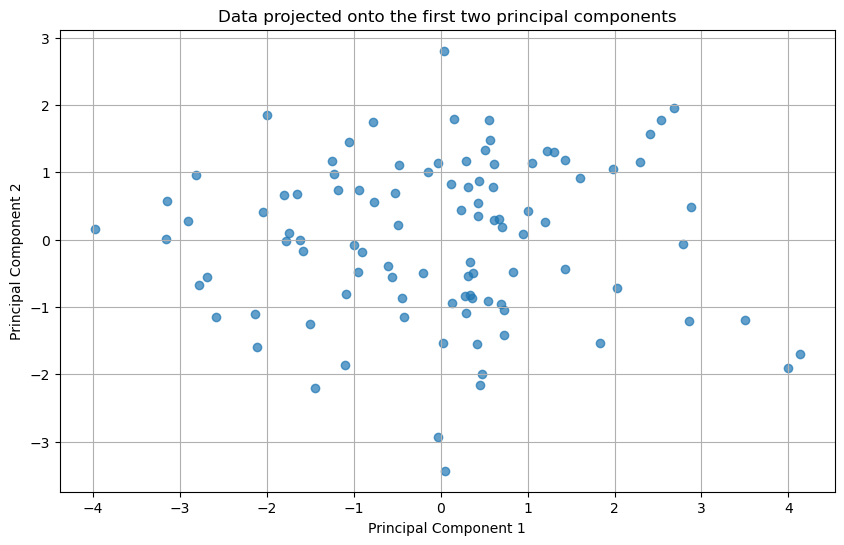

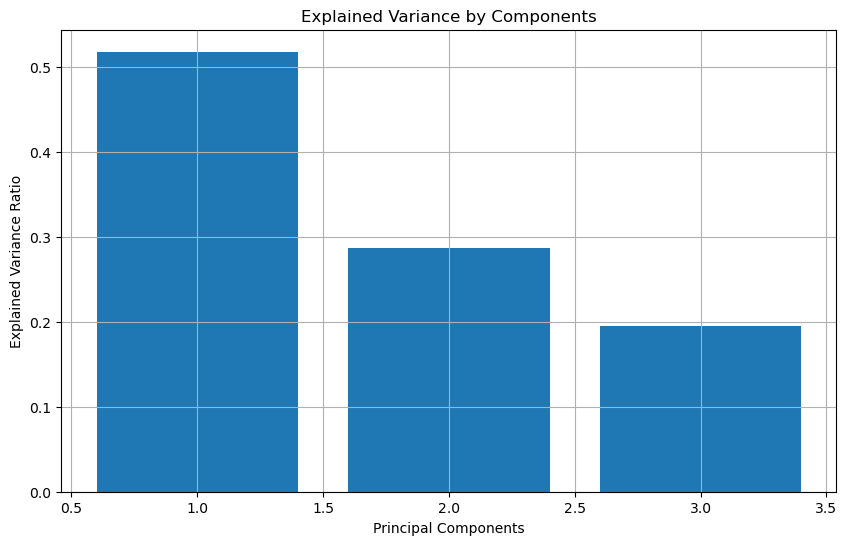

Standard PCA time: 0.9775 seconds
Dual PCA time: 0.0218 seconds
Speedup: 44.89x


In [3]:
## Implementation from Scratch


import numpy as np
import matplotlib.pyplot as plt

def pca_from_scratch(X, k=2):
    """
    Perform PCA on the data X to reduce to k dimensions.
    
    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data.
    k : int, optional (default=2)
        Number of principal components to retain.
        
    Returns:
    components : array, shape (n_features, k)
        Principal components (basis vectors).
    projected : array, shape (n_samples, k)
        Projected data (hidden variables).
    """
    # Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Compute scatter matrix
    scatter_matrix = X_centered.T @ X_centered
    
    # Compute eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(scatter_matrix)
    
    # Sort by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Select the top k eigenvectors
    components = eigenvectors[:, :k]
    
    # Project the data onto the principal components
    projected = X_centered @ components
    
    return components, projected, X_mean

# Example usage
# Generate random data with some correlation
np.random.seed(42)
n_samples = 100
mean = [0, 0, 0]  # 3D data
cov = [[3, 1, 0.5], [1, 2, 0.3], [0.5, 0.3, 1]]
X = np.random.multivariate_normal(mean, cov, n_samples)

# Perform PCA to reduce to 2 dimensions
components, projected, X_mean = pca_from_scratch(X, k=2)

# Reconstruct the data
X_reconstructed = projected @ components.T + X_mean

# Calculate reconstruction error
reconstruction_error = np.sum((X - X_reconstructed)**2)
print(f"Reconstruction error: {reconstruction_error:.4f}")

# Visualize 2D projection
plt.figure(figsize=(10, 6))
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.7)
plt.title('Data projected onto the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Visualize variance explained
eigenvalues = np.linalg.eigvalsh(X.T @ X)[::-1]
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title('Explained Variance by Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


## Dual PCA Implementation


def dual_pca_from_scratch(X, k=2):
    """
    Perform dual PCA on the data X to reduce to k dimensions.
    
    Parameters:
    X : array-like, shape (n_samples, n_features)
        The input data.
    k : int, optional (default=2)
        Number of principal components to retain.
        
    Returns:
    components : array, shape (n_features, k)
        Principal components (basis vectors).
    projected : array, shape (n_samples, k)
        Projected data (hidden variables).
    """
    # Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Compute Gram matrix (matrix of inner products)
    gram_matrix = X_centered @ X_centered.T
    
    # Compute eigenvectors and eigenvalues of the Gram matrix
    eigenvalues, dual_components = np.linalg.eigh(gram_matrix)
    
    # Sort by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    dual_components = dual_components[:, idx]
    
    # Select the top k dual components
    dual_components = dual_components[:, :k]
    
    # Normalize by eigenvalues
    for i in range(k):
        dual_components[:, i] /= np.sqrt(eigenvalues[i])
    
    # Compute actual components by projecting back
    components = X_centered.T @ dual_components
    
    # Project the data
    projected = X_centered @ components
    
    return components, projected, X_mean

# Example: Compare dual PCA vs standard PCA
# This is especially useful when dimensionality > number of samples
X_high_dim = np.random.rand(50, 1000)  # 50 samples, 1000 dimensions

# Time standard PCA
import time
start_time = time.time()
components1, projected1, mean1 = pca_from_scratch(X_high_dim, k=2)
standard_time = time.time() - start_time

# Time dual PCA
start_time = time.time()
components2, projected2, mean2 = dual_pca_from_scratch(X_high_dim, k=2)
dual_time = time.time() - start_time

print(f"Standard PCA time: {standard_time:.4f} seconds")
print(f"Dual PCA time: {dual_time:.4f} seconds")
print(f"Speedup: {standard_time/dual_time:.2f}x")


First principal component: [0.661327220352924, 0.6007607822530919, 0.44914673562982527]
Second principal component: [0.1519108079771769, 0.4791082472487603, -0.8645104937697067]
Eigenvalues: [88.85911346763255, 42.01608546018272]
Reconstruction error: 18.2288


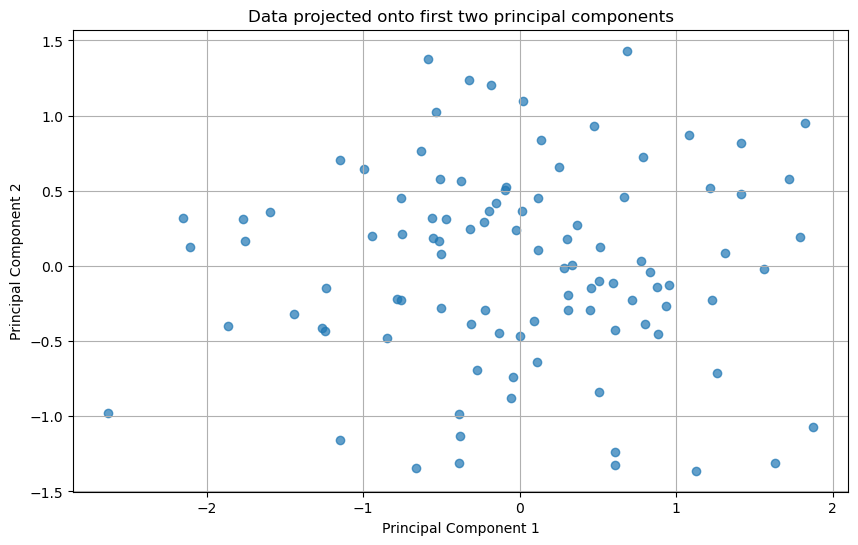

Standard PCA time: 0.5508 seconds
Dual PCA time: 0.0339 seconds
Speedup with dual PCA: 16.24x


In [4]:
import math
import random
import matplotlib.pyplot as plt

# Helper math functions for vector and matrix operations
def zeros_vector(n):
    """Create a zero vector of length n"""
    return [0.0 for _ in range(n)]

def zeros_matrix(rows, cols):
    """Create a zero matrix of size rows x cols"""
    return [[0.0 for _ in range(cols)] for _ in range(rows)]

def identity_matrix(n):
    """Create an identity matrix of size n x n"""
    matrix = zeros_matrix(n, n)
    for i in range(n):
        matrix[i][i] = 1.0
    return matrix

def dot_product(a, b):
    """Compute the dot product of vectors a and b"""
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def vector_subtract(a, b):
    """Subtract vector b from vector a"""
    return [a_i - b_i for a_i, b_i in zip(a, b)]

def vector_add(a, b):
    """Add vector b to vector a"""
    return [a_i + b_i for a_i, b_i in zip(a, b)]

def scalar_multiply(s, v):
    """Multiply vector v by scalar s"""
    return [s * v_i for v_i in v]

def vector_magnitude(v):
    """Compute the magnitude (length) of vector v"""
    return math.sqrt(sum(v_i ** 2 for v_i in v))

def normalize_vector(v):
    """Normalize a vector to unit length"""
    magnitude = vector_magnitude(v)
    if magnitude < 1e-10:  # Avoid division by zero
        return zeros_vector(len(v))
    return [v_i / magnitude for v_i in v]

def matrix_vector_multiply(matrix, vector):
    """Multiply a matrix by a vector"""
    return [dot_product(row, vector) for row in matrix]

def matrix_multiply(A, B):
    """Multiply matrix A by matrix B"""
    n_rows_A = len(A)
    n_cols_A = len(A[0])
    n_cols_B = len(B[0])
    
    C = zeros_matrix(n_rows_A, n_cols_B)
    
    for i in range(n_rows_A):
        for j in range(n_cols_B):
            for k in range(n_cols_A):
                C[i][j] += A[i][k] * B[k][j]
    
    return C

def transpose(matrix):
    """Compute the transpose of a matrix"""
    n_rows = len(matrix)
    n_cols = len(matrix[0]) if matrix else 0
    
    transposed = zeros_matrix(n_cols, n_rows)
    for i in range(n_rows):
        for j in range(n_cols):
            transposed[j][i] = matrix[i][j]
    
    return transposed

def compute_mean(data):
    """Compute the mean of a dataset"""
    n_samples = len(data)
    n_features = len(data[0])
    
    mean = zeros_vector(n_features)
    for i in range(n_samples):
        for j in range(n_features):
            mean[j] += data[i][j]
    
    return [m / n_samples for m in mean]

def center_data(data, mean):
    """Center the data by subtracting the mean"""
    return [vector_subtract(x, mean) for x in data]

def compute_covariance_matrix(data):
    """Compute the covariance matrix for centered data"""
    n_samples = len(data)
    n_features = len(data[0])
    
    cov = zeros_matrix(n_features, n_features)
    
    for i in range(n_features):
        for j in range(n_features):
            for k in range(n_samples):
                cov[i][j] += data[k][i] * data[k][j]
            
            cov[i][j] /= (n_samples - 1)  # Unbiased estimator
    
    return cov

def compute_scatter_matrix(data):
    """Compute the scatter matrix for centered data (XX^T)"""
    n_samples = len(data)
    n_features = len(data[0])
    
    scatter = zeros_matrix(n_features, n_features)
    
    for i in range(n_features):
        for j in range(n_features):
            for k in range(n_samples):
                scatter[i][j] += data[k][i] * data[k][j]
    
    return scatter

# Power iteration method to find dominant eigenvectors
def power_iteration(A, num_iterations=100, tol=1e-10):
    """Find the dominant eigenvector and eigenvalue of matrix A"""
    n = len(A)
    # Start with a random vector
    b = [random.random() for _ in range(n)]
    b = normalize_vector(b)
    
    for _ in range(num_iterations):
        # Calculate the matrix-vector product Ab
        b_next = matrix_vector_multiply(A, b)
        
        # Calculate the norm
        b_next_norm = vector_magnitude(b_next)
        
        # Re-normalize the vector
        b_next_normalized = [component / b_next_norm for component in b_next]
        
        # Check for convergence
        diff = sum((a - c)**2 for a, c in zip(matrix_vector_multiply(A, b), scalar_multiply(b_next_norm, b)))
        if diff < tol:
            break
            
        b = b_next_normalized
    
    # Calculate the Rayleigh quotient (eigenvalue)
    Ab = matrix_vector_multiply(A, b)
    eigenvalue = dot_product(b, Ab)
    
    return eigenvalue, b

def deflation(A, eigenvector, eigenvalue):
    """Deflate matrix A by removing the contribution of an eigenvector"""
    n = len(A)
    outer_product = zeros_matrix(n, n)
    for i in range(n):
        for j in range(n):
            outer_product[i][j] = eigenvector[i] * eigenvector[j] * eigenvalue
    
    result = zeros_matrix(n, n)
    for i in range(n):
        for j in range(n):
            result[i][j] = A[i][j] - outer_product[i][j]
    
    return result

def pca(data, k=2):
    """
    Perform PCA on the data to reduce it to k dimensions.
    
    Parameters:
    data: List of lists, where each inner list is a data point
    k: Number of principal components to keep
    
    Returns:
    components: List of lists, where each inner list is a principal component
    projected: List of lists, where each inner list is a projected data point
    mean: Mean of the data
    """
    # Calculate mean and center data
    mean = compute_mean(data)
    centered_data = center_data(data, mean)
    
    # Calculate scatter matrix
    scatter = compute_scatter_matrix(centered_data)
    
    # Find k eigenvectors using power iteration
    components = []
    eigenvalues = []
    
    A = scatter.copy()
    for _ in range(k):
        eigenvalue, eigenvector = power_iteration(A)
        components.append(eigenvector)
        eigenvalues.append(eigenvalue)
        
        # Deflate the matrix to find the next eigenvector
        A = deflation(A, eigenvector, eigenvalue)
    
    # Transpose components for easier projection
    components_transposed = transpose(components)
    
    # Project data onto principal components
    projected = []
    for x in centered_data:
        projected_point = []
        for component in components:
            projected_point.append(dot_product(x, component))
        projected.append(projected_point)
    
    return components, projected, mean, eigenvalues

# Generate synthetic data
def generate_correlated_data(n_samples, dim=3, seed=42):
    """Generate synthetic data with correlation"""
    random.seed(seed)
    
    # Create a correlation structure
    data = []
    for _ in range(n_samples):
        # Generate a base value
        base = random.gauss(0, 1)
        
        # Generate correlated dimensions
        point = []
        for i in range(dim):
            # Each dimension depends partly on the base value and partly on random noise
            correlation = 0.7 - (i * 0.2)  # Decreasing correlation for each dimension
            noise = random.gauss(0, 1) * (1 - correlation)
            value = (correlation * base) + noise
            point.append(value)
        
        data.append(point)
    
    return data

# Function to reconstruct data from PCA components
def reconstruct_data(projected, components, mean):
    """Reconstruct the data from its PCA projection"""
    reconstructed = []
    
    for proj in projected:
        # For each projected point, multiply by components to get back to original space
        recon_point = zeros_vector(len(mean))
        
        for i, p in enumerate(proj):
            component = components[i]
            scaled_component = scalar_multiply(p, component)
            recon_point = vector_add(recon_point, scaled_component)
        
        # Add back the mean
        recon_point = vector_add(recon_point, mean)
        reconstructed.append(recon_point)
    
    return reconstructed

# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """Calculate the sum of squared reconstruction errors"""
    total_error = 0
    for orig, recon in zip(original, reconstructed):
        diff = vector_subtract(orig, recon)
        error = sum(d*d for d in diff)
        total_error += error
    return total_error

# Dual PCA implementation
def dual_pca(data, k=2):
    """
    Perform dual PCA on the data to reduce it to k dimensions.
    More efficient when number of features > number of samples.
    
    Parameters:
    data: List of lists, where each inner list is a data point
    k: Number of principal components to keep
    
    Returns:
    components: List of lists, where each inner list is a principal component
    projected: List of lists, where each inner list is a projected data point
    mean: Mean of the data
    """
    # Calculate mean and center data
    mean = compute_mean(data)
    centered_data = center_data(data, mean)
    
    # Calculate Gram matrix (inner products between samples)
    n_samples = len(centered_data)
    gram = zeros_matrix(n_samples, n_samples)
    
    for i in range(n_samples):
        for j in range(n_samples):
            gram[i][j] = dot_product(centered_data[i], centered_data[j])
    
    # Find k eigenvectors of the Gram matrix
    dual_components = []
    eigenvalues = []
    
    A = gram.copy()
    for _ in range(k):
        eigenvalue, eigenvector = power_iteration(A)
        dual_components.append(eigenvector)
        eigenvalues.append(eigenvalue)
        
        # Deflate the matrix
        A = deflation(A, eigenvector, eigenvalue)
    
    # Convert dual eigenvectors to data space eigenvectors
    components = []
    for i in range(k):
        # Normalize by eigenvalue
        scaling = 1.0 / math.sqrt(eigenvalues[i]) if eigenvalues[i] > 0 else 0
        
        # Linear combination of data points
        component = zeros_vector(len(data[0]))
        for j in range(n_samples):
            scaled_point = scalar_multiply(dual_components[i][j] * scaling, centered_data[j])
            component = vector_add(component, scaled_point)
            
        # Normalize
        component = normalize_vector(component)
        components.append(component)
    
    # Project data onto principal components
    projected = []
    for x in centered_data:
        projected_point = []
        for component in components:
            projected_point.append(dot_product(x, component))
        projected.append(projected_point)
    
    return components, projected, mean, eigenvalues

# Main execution
if __name__ == "__main__":
    # Generate synthetic data (3D with correlations)
    data = generate_correlated_data(100, dim=3)
    
    # Perform PCA to reduce to 2 dimensions
    components, projected, mean, eigenvalues = pca(data, k=2)
    
    print("First principal component:", components[0])
    print("Second principal component:", components[1])
    print("Eigenvalues:", eigenvalues)
    
    # Reconstruct the data
    reconstructed = reconstruct_data(projected, components, mean)
    
    # Calculate reconstruction error
    error = calculate_reconstruction_error(data, reconstructed)
    print(f"Reconstruction error: {error:.4f}")
    
    # Visualize the projected data
    plt.figure(figsize=(10, 6))
    plt.scatter([p[0] for p in projected], [p[1] for p in projected], alpha=0.7)
    plt.title('Data projected onto first two principal components')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()
    
    # Compare standard PCA with dual PCA for a high-dimensional case
    # Create a small dataset with high dimensionality
    high_dim_data = []
    for _ in range(20):  # 20 samples
        high_dim_data.append([random.random() for _ in range(100)])  # 100 dimensions
    
    import time
    
    # Time standard PCA
    start_time = time.time()
    pca(high_dim_data, k=2)
    standard_time = time.time() - start_time
    
    # Time dual PCA
    start_time = time.time()
    dual_pca(high_dim_data, k=2)
    dual_time = time.time() - start_time
    
    print(f"Standard PCA time: {standard_time:.4f} seconds")
    print(f"Dual PCA time: {dual_time:.4f} seconds")
    if dual_time > 0:
        print(f"Speedup with dual PCA: {standard_time/dual_time:.2f}x")

## K-means Algorithm and Dimensionality Reduction

A second common approach to dimensionality reduction is to abandon a continuous representation altogether and represent each data point using one of a limited set of prototype vectors. In this model, the data are approximated as:

$$
x_i \approx \mu_{h_i}, \quad (13.31)
$$

where $ h_i \in \{1, 2, \dots, K\} $ is an index that identifies which of the $ K $ prototype vectors $ \{\mu_k\}_{k=1}^K $ approximates the $ i $-th example. To find the assignment indices and the prototype vectors (see Figure 13.20), we optimize:

$$
\hat{\mu}_{1\dots K}, \hat{h}_{1\dots I} = \arg\min_{\mu, h} \sum_{i=1}^I (x_i - \mu_{h_i})^T (x_i - \mu_{h_i}). \quad (13.32)
$$

In the K-means algorithm, this cost function is minimized using an alternating strategy. First, we assign each data point to the nearest prototype:

$$
\hat{h}_i = \arg\min_{h_i} (x_i - \mu_{h_i})^T (x_i - \mu_{h_i}), \quad (13.33)
$$

and then update the prototypes:

$$
\hat{\mu}_k = \arg\min_{\mu_k} \sum_{i=1}^I (x_i - \mu_{h_i})^T (x_i - \mu_{h_i}),
$$

which simplifies to:

$$
\hat{\mu}_k = \frac{\sum_{i=1}^I x_i \delta[h_i - k]}{\sum_{i=1}^I \delta[h_i - k]}, \quad (13.34)
$$

where $ \delta[\cdot] $ is a function that returns one when its argument is zero and zero otherwise. In other words, the new prototype $ \hat{\mu}_k $ is simply the average of the data points assigned to this cluster.

## Fig.20: K-means Algorithm for $ K = 3 $ Clusters

- **a)** We initialize the three prototype vectors (crosses) to random positions.
- **b)** Assign the data to the nearest prototype vector.
- **c)** Update the prototype vectors to be equal to the mean of the points assigned to them.
- **d-i)** Repeat these steps until there is no further change.

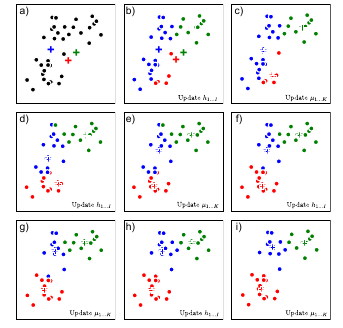
20. K-means algorithm for K = 3 clusters. a) We initialize the three prototype vectors (crosses) to random positions. We alternately b) assign the data to the nearest prototype vector and c) update the prototype vectors to be equal to the mean of the points assigned to them. d-i) We repeat these steps until there is no further change.

## Additional Notes

This algorithm is not guaranteed to converge to the global minimum and so it requires sensible starting conditions. The K-means algorithm is very closely related to the mixtures of Gaussians model (section 7.4). The main differences are that the mixtures of Gaussians model is probabilistic and defines a density over the data space. It also assigns weights to the clusters and describes their covariance.

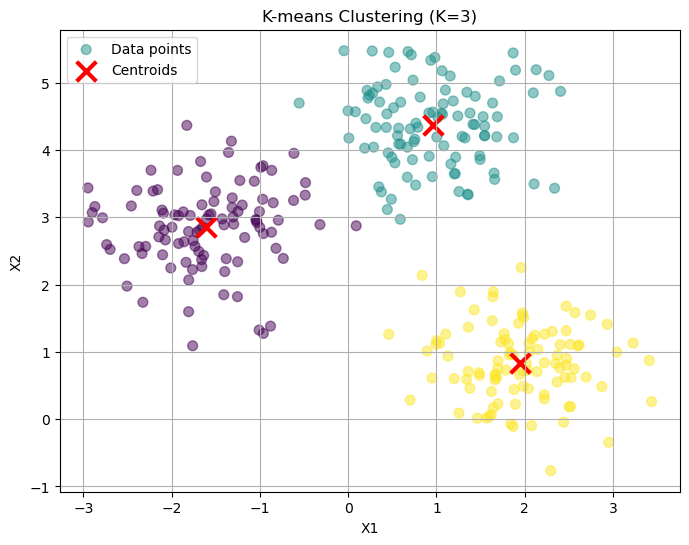

Final centroids:
[[-1.60811992  2.85881658]
 [ 0.95625704  4.37226546]
 [ 1.95159369  0.83467497]]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic 2D data with 3 clusters
X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

# K-means implementation
def k_means(X, K, max_iters=100):
    # Step 1: Randomly initialize K centroids
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, K, replace=False)]
    labels = np.zeros(n_samples)
    
    for _ in range(max_iters):
        # Step 2: Assign points to the nearest centroid
        old_labels = labels.copy()
        distances = np.zeros((n_samples, K))
        for k in range(K):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)
        labels = np.argmin(distances, axis=1)
        
        # Step 3: Update centroids
        for k in range(K):
            if np.any(labels == k):  # Avoid division by zero
                centroids[k] = np.mean(X[labels == k], axis=0)
        
        # Check for convergence
        if np.all(old_labels == labels):
            break
    
    return centroids, labels

# Run K-means with K=3
K = 3
centroids, labels = k_means(X, K)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.title(f'K-means Clustering (K={K})')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()

# Print final centroids
print("Final centroids:")
print(centroids)

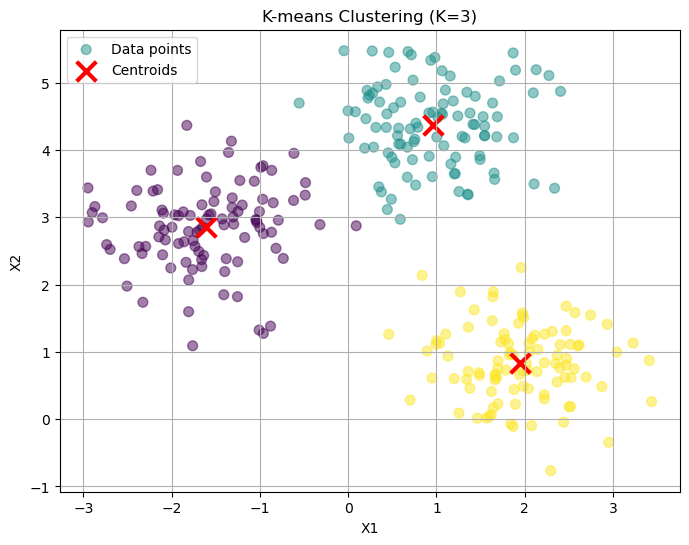

Final centroids:
[[-1.60811992  2.85881658]
 [ 0.95625704  4.37226546]
 [ 1.95159369  0.83467497]]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

np.random.seed(42)

X, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

def k_means(X, K, max_iters=100):
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, K, replace=False)]
    labels = np.zeros(n_samples)
    
    for _ in range(max_iters):
        old_labels = labels.copy()
        distances = np.zeros((n_samples, K))
        for k in range(K):
            distances[:, k] = np.sum((X - centroids[k])**2, axis=1)
        labels = np.argmin(distances, axis=1)
        
        for k in range(K):
            if np.any(labels == k):
                centroids[k] = np.mean(X[labels == k], axis=0)
        
        if np.all(old_labels == labels):
            break
    
    return centroids, labels

K = 3
centroids, labels = k_means(X, K)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5, label='Data points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.title(f'K-means Clustering (K={K})')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.grid(True)
plt.show()

print("Final centroids:")
print(centroids)

# Notes on Image Processing

There are numerous texts on image processing that contain far more information than could be included in this chapter. I would particularly recommend the books by O’Gorman et al. (2008), Gonzalez & Woods (2002), Pratt (2007), and Nixon & Aguado (2008). A comprehensive recent summary of local image features can be found in Li & Allinson (2008).

## Edge and Corner Detection

The Canny edge detector was first described in Canny (1986). Elder (1999) investigated whether it was possible to reconstruct an image based on edge information alone. Nowadays, it is common to use machine learning methods to identify object boundaries in images (e.g., Dollár et al. 2006).

Early work in corner detection (interest point detection) includes that of Moravec (1983), Förstner (1986), and the Harris corner detector (Harris & Stephens 1988), which we described in this chapter. Other more recent efforts to identify stable points and regions include:

- The SUSAN corner detector (Smith & Brady 1997),
- A saliency-based descriptor (Kadir & Brady 2001),
- Maximally stable extremal regions (Matas et al. 2002),
- The SIFT detector (Lowe 2004),
- The FAST detector (Rosten & Drummond 2006).

There has been considerable recent interest in affine invariant interest point detection, which aims to find features that are stable under affine transforms of the image (e.g., Schaffalitzky & Zisserman 2002; Mikolajczyk & Schmid 2002; Mikolajczyk & Schmid 2004). Mikolajczyk et al. (2005) present a quantitative comparison of different affine region detectors. A recent review of this area can be found in Tuytelaars & Mikolajczyk (2007).

## Image Descriptors

For robust object recognition and image matching, it is crucial to characterize the region around the detected interest point in a way that is compact and stable to changes in the image. To this end:

- Lowe (2004) developed the SIFT descriptor,
- Dalal & Triggs (2005) developed the HOG descriptor,
- Forssén & Lowe (2007) developed a descriptor for use with maximally stable extremal regions,
- Bay et al. (2008) developed a very efficient version of SIFT features known as SURF.

Mikolajczyk & Schmid (2005) present a quantitative comparison of region descriptors. Recent work on image descriptors has applied machine learning techniques to optimize their performance (Brown et al. 2011; Philbin et al. 2010). More information about local binary patterns can be found in Ojala et al. (2002). More information about the shape context descriptor can be found in Belongie et al. (2002).

## Dimensionality Reduction

Principal components analysis (PCA) is a linear dimensionality reduction method. However, there are also many nonlinear approaches that describe a manifold of images in high dimensions with fewer parameters. Notable methods include:

- Kernel PCA (Schölkopf et al. 1997),
- ISOMAP (Tenenbaum et al. 2000),
- Local Linear Embedding (Roweis & Saul 2000),
- Charting (Brand 2002),
- The Gaussian Process Latent Variable Model (Lawrence 2004),
- Laplacian Eigenmaps (Belkin & Niyogi 2001).

Recent reviews of dimensionality reduction can be found in Burgess (2010) and De La Torre (2011).

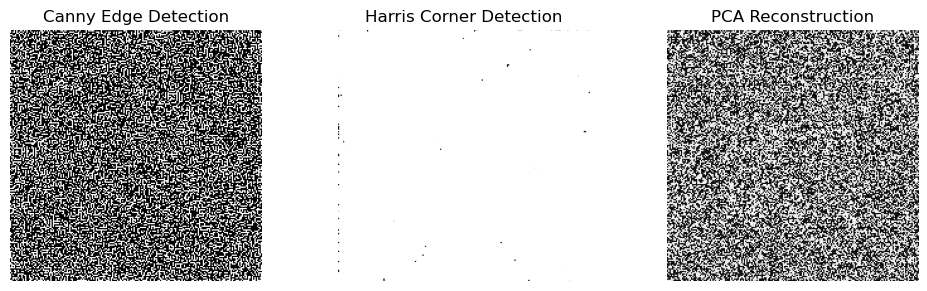

Explained variance ratio: [1.]


In [8]:
# Image Processing Implementation

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate a synthetic image (e.g., a square with noise)
def create_synthetic_image(size=200):
    img = np.zeros((size, size), dtype=np.uint8)
    img[50:150, 50:150] = 255  # Draw a white square
    noise = np.random.normal(0, 25, (size, size)).astype(np.uint8)
    img = np.clip(img + noise, 0, 255)
    return img

# Load and preprocess image
img = create_synthetic_image()
plt.figure(figsize=(10, 3))

# 1. Edge Detection (Canny)
edges = cv2.Canny(img, 100, 200)
plt.subplot(131)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

# 2. Corner Detection (Harris)
img_float = np.float32(img)
harris = cv2.cornerHarris(img_float, blockSize=2, ksize=3, k=0.04)
# Dilate to enhance corners
harris = cv2.dilate(harris, None)
# Threshold to mark corners
img_corners = img.copy()
img_corners[harris > 0.01 * harris.max()] = 255
plt.subplot(132)
plt.imshow(img_corners, cmap='gray')
plt.title('Harris Corner Detection')
plt.axis('off')

# 3. Dimensionality Reduction (PCA)
# Flatten the image to a vector for PCA
img_vector = img.reshape(-1, 1)  # Treat each pixel as a feature
pca = PCA(n_components=1)  # Reduce to 1D for demonstration
img_pca = pca.fit_transform(img_vector)
img_reconstructed = pca.inverse_transform(img_pca).reshape(img.shape)
plt.subplot(133)
plt.imshow(img_reconstructed, cmap='gray')
plt.title('PCA Reconstruction')
plt.axis('off')

plt.tight_layout()
plt.show()

# Print explained variance ratio from PCA
print("Explained variance ratio:", pca.explained_variance_ratio_)